# Assessing the precedent for the 2019/20 FFDI and DI values in the historical record

### Time taken: < 1 min 

#### This notebook includes the creation of Fig 2 and Fig S1

------

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import geopandas
import regionmask

import xskillscore as xs

import myfuncs as my

import dask.bag as db

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

In [2]:
cartopy.config['pre_existing_data_dir'] = '/g/data/v14/ds0092/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/v14/ds0092/data/cartopy-data'

--------
# Parameters

In [3]:
REGION_MASK = xr.open_dataset('./data/region_mask.ONDJF.10.nc')['region_mask']
cafe_area = my.open_zarr(
    '/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20201101/atmos_isobaric_daily.zarr.zip',
    preprocess=my.truncate_latitudes)['area']

--------
# Load historical data

In [3]:
jra_FFDI_reg = my.open_zarr(
    'data/JRA-55_FFDI-DEC-mean_region.zarr')
jra_FFDI_cafegrid = my.open_zarr(
    'data/JRA-55_FFDI-DEC-mean_cafegrid.zarr')
jra_FFDI_jragrid = my.open_zarr(
    'data/JRA-55_FFDI-DEC-mean_jragrid.zarr')

awap_DI_reg = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_region.zarr',
    open_zarr_kwargs={'use_cftime':True})
awap_DI_awapgrid = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_awapgrid.zarr',
    open_zarr_kwargs={'use_cftime':True})
awap_DI_jragrid = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_jragrid.zarr',
    open_zarr_kwargs={'use_cftime':True})
awap_DI_cafegrid = my.open_zarr(
    'data/AWAP_precip-annDEC-accl_cafegrid.zarr',
    open_zarr_kwargs={'use_cftime':True})

In [4]:
jra_FFDI_reg, awap_DI_reg = xr.align(jra_FFDI_reg, awap_DI_reg)
jra_FFDI_cafegrid, awap_DI_cafegrid = xr.align(jra_FFDI_cafegrid, awap_DI_cafegrid)
jra_FFDI_jragrid, awap_DI_jragrid = xr.align(jra_FFDI_jragrid, awap_DI_jragrid)
jra_FFDI_jragrid, awap_DI_awapgrid = xr.align(jra_FFDI_jragrid, awap_DI_awapgrid,
                                             exclude=['lat','lon'])

--------
# Use NSW burned area data to identify years where burned area in our region was particularly high

#### Create high-res mask of NSW to use to rasterize NPWS Fire History shape files

In [6]:
lons = np.arange(140.5, 153.8, 0.05)
lats = np.arange(-38.5,   -28, 0.05)
NSW_grid = xr.DataArray(np.ones((len(lons), len(lats))), coords=[lons, lats], dims=['lon', 'lat'])

NSW = geopandas.read_file("./data/nsw_state_polygon_shp/NSW_STATE_POLYGON_shp.shp")
NSW_mask = regionmask.Regions_cls(name='NSW', 
                                  numbers=list(NSW.index), 
                                  names=list(NSW.STATE_NAME), 
                                  abbrevs=list(NSW.ST_ABBREV), 
                                  outlines=list(NSW.geometry))
NSW_mask = NSW_mask.mask(NSW_grid, lon_name='lon', lat_name='lat')

#### Rasterize NPWS Fire History shape files

In [7]:
def rasterize(df, grid, includes_month = None, fire_type = 'Wildfire', with_dask=True):
    """ Rasterize States and Territories burned area data
        If includes_month is provided, exclude fires that have start and end dates that do not
        either fall 28 days before or after of the specified month, respectively, or span a 
        period encompassing the month
    """
    df['Year'] = df['Label'].str.split('-').str[0]
    df['StartMonth'] = pd.DatetimeIndex(df['StartDate']).month
    df['EndMonth'] = pd.DatetimeIndex(df['EndDate']).month
    
    if includes_month:
        include_month_start = pd.DatetimeIndex(df['Year']+'-'+str(includes_month))
        include_month_end = include_month_start + pd.tseries.offsets.MonthEnd(0)
        
        falls_between = ((pd.DatetimeIndex(df['StartDate']) <= include_month_start) & \
                          (pd.DatetimeIndex(df['EndDate']) >= include_month_start)) | \
                        ((pd.DatetimeIndex(df['StartDate']) <= include_month_end) & \
                          (pd.DatetimeIndex(df['EndDate']) >= include_month_end))
        close_to_start = abs(include_month_start - pd.DatetimeIndex(df['StartDate'])).days < 28
        close_to_end = abs(pd.DatetimeIndex(df['EndDate']) - include_month_end).days < 28
        both_None = df['StartDate'].isnull() & df['EndDate'].isnull()
        month_mask = falls_between | close_to_start | close_to_end | both_None
        
        df_mask = df[month_mask]
    else:
        df_mask = df

    # Apply mask for fire type
    type_mask = df_mask['Label'].str.contains(fire_type)
    df_mask = df_mask[type_mask]
    
    def _get_regions_for_year(year, df):
        df_tmp = df[df['Year'] == year]
        rmask = regionmask.Regions_cls(name='tmp', 
                                       numbers=np.arange(len(df_tmp.geometry)), 
                                       names=list(df_tmp.Label),
                                       abbrevs=list(df_tmp.Label), 
                                       outlines=list(df_tmp.geometry))
        return xr.where(rmask.mask(grid, lon_name='lon', lat_name='lat', wrap_lon=True).notnull(), 1, 0)
    
    if with_dask:
        b = db.from_sequence(np.unique(df_mask['Year'].sort_values()), npartitions=100)
        to_concat = b.map(_get_regions_for_year, df_mask).compute()
    else:
        to_concat = []
        for year in np.unique(df_mask['Year'].sort_values()):
            to_concat.append(_get_regions_for_year(year, df_mask))

    data = xr.concat(to_concat, dim='time')
    return  data.assign_coords({'time': np.unique(df_mask['Year'].sort_values()).astype(np.datetime64)})

In [8]:
NPWS = geopandas.read_file("./data/firenpwsfirehistory/NPWSFireHistory_17122020.shp")
NPWS

,FireName,FireNo,Label,StartDate,EndDate,AreaHa,PerimeterM,VerDate,geometry
0,None,None,1968-69 Prescribed Burn,1968-10-01,None,2.184770,1548.960666,17/12/2020,"POLYGON ((153.14143 -30.17730, 153.14144 -30.1..."
1,None,None,1970-71 Prescribed Burn,None,None,299.985464,8615.637120,17/12/2020,"POLYGON ((152.77796 -31.63806, 152.77822 -31.6..."
2,None,70/161,1970-71 Prescribed Burn,None,None,309.025645,20657.633993,17/12/2020,"POLYGON ((151.50894 -31.98245, 151.50911 -31.9..."
3,None,None,1970-71 Prescribed Burn,1970-07-01,None,13.600002,1999.487701,17/12/2020,"POLYGON ((153.14728 -30.17573, 153.14721 -30.1..."
4,None,0,1971-72 Prescribed Burn,1971-07-01,None,58.994371,5312.210152,17/12/2020,"POLYGON ((152.21270 -32.24101, 152.21272 -32.2..."
...,...,...,...,...,...,...,...,...,...
34467,"Badja Forest Rd, Countegany",19122766937,2019-20 Wildfire,2019-12-26,2020-03-03,9.312387,1407.032773,17/12/2020,"POLYGON ((149.81549 -36.44683, 149.81555 -36.4..."
34468,Brookdale,20121102295,2020-21 Wildfire,2020-12-10,2020-12-10,0.183921,185.430973,17/12/2020,"POLYGON ((147.04841 -35.05394, 147.04836 -35.0..."
34469,B H Line Road,20120801055,2020-21 Wildfire,2020-12-07,2020-12-13,12.413017,1342.049088,17/12/2020,"POLYGON ((148.86701 -30.59654, 148.86762 -30.5..."
34470,MAC Grey street SFAZ,HR16011275584,2017-18 Prescribed Burn,2017-07-27,2017-08-03,4.507357,1165.560496,17/12/2020,"POLYGON ((153.06877 -30.89195, 153.06759 -30.8..."


In [9]:
%%time
clobber = False

if clobber:
    from dask.distributed import LocalCluster, Client
    cluster = LocalCluster()
    client = Client(cluster)
    
    burned_NSW = rasterize(NPWS, NSW_grid, includes_month=12)
    burned_NSW.to_netcdf('./data/NSW_burned_wildfire_regions.includes_DEC.nc')
    
    cluster.close()
    client.close()
else:
    burned_NSW = xr.open_dataset('./data/NSW_burned_wildfire_regions.includes_DEC.nc')['region']
    
REGION_MASK_NSW_grid = REGION_MASK.interp(coords={'lat': NSW_grid.lat, 'lon': NSW_grid.lon}, method='nearest')

CPU times: user 21.9 ms, sys: 3.38 ms, total: 25.3 ms
Wall time: 53.5 ms


### Years of "large" burned area

In [10]:
NSW_grid_area = my.estimate_cell_areas(REGION_MASK_NSW_grid)
percent_burned_NSW = 100 * burned_NSW.where(REGION_MASK_NSW_grid).weighted(
    NSW_grid_area).mean(['lat','lon'], skipna=True)

In [11]:
thresh = 1.2

bad_years = percent_burned_NSW.where(percent_burned_NSW > thresh, drop=True).time.dt.year.values

print(f'These are years when fires burned over '+
      f'{(thresh / 100) * cafe_area.where(REGION_MASK, drop=True).sum().values / 10000} hectares:')
print(bad_years)

These are years when fires burned over 247445.6580096 hectares:
[1938 1968 1979 1980 1982 1993 1997 2001 2002 2019]


## Plot Fig 2 for paper

In [12]:
# Choose shades of bad years to keep colormap perceptually uniform
years = jra_FFDI_reg.time.dt.year.values
bad_years = [year for year in bad_years if year in years]
shades = [0.03, 0.115, 0.125, 0.143, 0.275, 0.34, 0.41, 0.41, 0.68]

custom_colors = (0 + cm.get_cmap('Greys')(np.linspace(0, 0.8, len(years)))) / 1
for year, shade in zip(bad_years, shades):
    custom_colors[np.where(years == year)[0]] = cm.get_cmap('magma_r')(shade)
custom_cmap = matplotlib.colors.ListedColormap(custom_colors, name='custom_cmap')

In [27]:
def plot_Fig_2(FFDI_reg, DI_reg, FFDI_native, DI_native, FFDI_matched, DI_matched, 
               FFDI_inset, DI_inset, bad_years, custom_cmap, figsize=(15,10)):
    def _plot_region_mask(mask):
        """ Plot mask as patches """
        import matplotlib.patches as mpatches
        dlon = np.diff(mask.lon)[0]
        dlat = np.diff(mask.lat)[0]
        for j, i in np.column_stack(np.where(mask)):
            ax.add_patch(
                mpatches.Rectangle((mask.lon[i]-dlon/2, mask.lat[j]-dlat/2), dlon, dlat,    
                                   fill=False, linewidth=1.5, snap=False, color='w', zorder=2))
        for j, i in np.column_stack(np.where(mask)):
            ax.add_patch(
                mpatches.Rectangle((mask.lon[i]-dlon/2, mask.lat[j]-dlat/2), dlon, dlat,    
                                   fill=False, linewidth=0.75, snap=False, hatch='', color='k', zorder=2))
            
    def kde(x, y, npoints=60):
        """ 2D kernel density estimate """
        from scipy import stats
        x_I, y_I = np.mgrid[0.5*x.min().values:2*x.max().values:np.complex(npoints), 
                            0.5*y.min().values:2*y.max().values:np.complex(npoints)]
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]
        positions = np.vstack([x_I.ravel(), y_I.ravel()])
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values)
        KDE = np.reshape(kernel(positions).T, x_I.shape)
        return x_I, y_I, KDE

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(ncols=3, nrows=4, figure=fig,width_ratios=[3,1,0.56])

    region = [111.5, 155, -45.5, -9]
    inset = [143.5, 154.2, -44.3, -28]
    arms = [161.8, 161.8, -45.5, -8.9]

    # FFDI native res =====================================================================
    ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
    notnans = FFDI_native.mean('time').notnull()
    FFDI_max = FFDI_native.fillna(0).argmax('time')
    FFDI_max.values = FFDI_native.time.dt.year[FFDI_max.values.flatten()].values.reshape(FFDI_max.shape)
    p = FFDI_max.where(notnans).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        vmin=FFDI_native.time.dt.year.min().values,
        vmax=FFDI_native.time.dt.year.max().values,
        cmap=custom_cmap, add_colorbar=False, rasterized=True)

    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.plot([inset[0], inset[1], inset[1], inset[0], inset[0]],
            [inset[2], inset[2], inset[3], inset[3], inset[2]], 
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree())
    ax.plot([inset[0], arms[0]], [inset[2], arms[2]],
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree(), clip_on = False)
    ax.plot([inset[0], arms[0]], [inset[3], arms[3]],
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree(), clip_on = False)
    ax.set_xlim((region[0], region[1]))
    ax.set_ylim((region[2], region[3]))

    ax.set_title('')
    ax.text(107.3, -11.5, r'$\bf{b}$')
    ax.text(0.03, 0.01, r'FFDI$_{\mathrm{Dec}}$',
            horizontalalignment='left',
            verticalalignment='bottom',
            transform = ax.transAxes)

    # FFDI inset =====================================================================
    ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
    p = FFDI_max.where(notnans).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        vmin=FFDI_inset.time.dt.year.min().values,
        vmax=FFDI_inset.time.dt.year.max().values,
        cmap=custom_cmap, add_colorbar=False, rasterized=True)
    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.set_xlim((inset[0], inset[1]))
    ax.set_ylim((inset[2], inset[3]))
    _plot_region_mask(REGION_MASK)  
    ax.set_title('')

    # DI native res =====================================================================
    ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
    notnans = DI_native.mean('time').notnull()
    DI_min = DI_native.fillna(0).argmin('time', skipna=True)
    DI_min.values = DI_native.time.dt.year[DI_min.values.flatten()].values.reshape(DI_min.shape)
    p = DI_min.where(notnans).plot(
        ax=ax, transform=ccrs.PlateCarree(), 
        vmin=DI_native.time.dt.year.min().values,
        vmax=DI_native.time.dt.year.max().values,
        cmap=custom_cmap, add_colorbar=False, rasterized=True)

    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.plot([inset[0], inset[1], inset[1], inset[0], inset[0]],
            [inset[2], inset[2], inset[3], inset[3], inset[2]], 
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree())
    ax.plot([inset[0], arms[0]], [inset[2], arms[2]],
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree(), clip_on = False)
    ax.plot([inset[0], arms[0]], [inset[3], arms[3]],
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree(), clip_on = False)
    ax.set_xlim((region[0], region[1]))
    ax.set_ylim((region[2], region[3]))

    ax.set_title('')
    ax.text(0.03, 0.01, r'DI',
            horizontalalignment='left',
            verticalalignment='bottom',
            transform = ax.transAxes)
    ax.text(107.3, -11.5, r'$\bf{c}$')

    # DI inset =====================================================================
    ax = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
    p = DI_min.where(notnans).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        vmin=DI_inset.time.dt.year.min().values,
        vmax=DI_inset.time.dt.year.max().values,
        cmap=custom_cmap,add_colorbar=False, rasterized=True)
    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.set_xlim((inset[0], inset[1]))
    ax.set_ylim((inset[2], inset[3]))
    _plot_region_mask(REGION_MASK)
    ax.set_title('')

    # Joint matched res =====================================================================
    def _dist(FFDI, DI):
        """ Distance from mean """
        FFDI_dist = (FFDI - FFDI.mean('time')) / FFDI.std('time')
        DI_dist = (DI - DI.mean('time')) / DI.std('time')
        return xr.ufuncs.sqrt(FFDI_dist**2 + DI_dist**2)

    ax = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())
    dist = _dist(FFDI_matched, DI_matched)
    notnans = DI_matched.mean('time').notnull()
    dist_max = dist.fillna(0).argmax('time', skipna=True)
    dist_max.values = dist.time.dt.year[dist_max.values.flatten()].values.reshape(dist_max.shape)
    p = dist_max.where(notnans).plot(
        ax=ax, transform=ccrs.PlateCarree(), 
        vmin=dist.time.dt.year.min().values,
        vmax=dist.time.dt.year.max().values,
        cmap=custom_cmap,add_colorbar=False, rasterized=True)

    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.plot([inset[0], inset[1], inset[1], inset[0], inset[0]],
            [inset[2], inset[2], inset[3], inset[3], inset[2]], 
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree())
    ax.plot([inset[0], arms[0]], [inset[2], arms[2]],
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree(), clip_on = False)
    ax.plot([inset[0], arms[0]], [inset[3], arms[3]],
            color='k', linestyle='--', linewidth=0.75,
            transform=ccrs.PlateCarree(), clip_on = False)
    ax.set_xlim((region[0], region[1]))
    ax.set_ylim((region[2], region[3]))

    ax.set_title('')
    ax.text(0.03, 0.01, r'Both',
            horizontalalignment='left',
            verticalalignment='bottom',
            transform = ax.transAxes)
    ax.text(107.3, -11.5, r'$\bf{d}$')

    # Joint inset =====================================================================
    ax = fig.add_subplot(gs[2, 2], projection=ccrs.PlateCarree())
    p = dist_max.where(notnans).plot(
        ax=ax, transform=ccrs.PlateCarree(), 
        vmin=dist.time.dt.year.min().values,
        vmax=dist.time.dt.year.max().values,
        cmap=custom_cmap,add_colorbar=False, rasterized=True)

    p.axes.coastlines(color=[0.3,0.3,0.3], linewidth=0.5)
    ax.set_xlim((inset[0], inset[1]))
    ax.set_ylim((inset[2], inset[3]))
    _plot_region_mask(REGION_MASK)
    ax.set_title('')

    # Scatter plot =====================================================================
    ax = fig.add_subplot(gs[0:3, 0])
    ax.grid(zorder=-2, linewidth=0.5)
    xx, yy, f = kde(FFDI_reg, DI_reg)
    ax.set_xlim(0.5*FFDI_reg.min(), 1.05*FFDI_reg.max())
    ax.set_ylim(0.9*DI_reg.min(), 1.05*DI_reg.max())
    levels = np.arange(1.5e-4, 7.5e-4, 2e-4)
    cfset = ax.contour(xx, yy, f, levels, 
                       colors='k', linewidths=0.75, linestyles='--', zorder=1)

    ax.set_xlabel(r'$\overline{\mathrm{FFDI}}_\mathrm{Dec}$')
    ax.set_ylabel(r'$\overline{\mathrm{DI}}$')
    ax.invert_yaxis()
    ax.set_title('')
    ax.text(0.75, 520, r'$\bf{a}$')

    min_year = min(FFDI_reg.time.dt.year)
    max_year = max(FFDI_reg.time.dt.year)
    s = ax.scatter(FFDI_reg, DI_reg, s=30, c=FFDI_reg.time.dt.year, 
                   edgecolor='k', lw=0.75, vmin=min_year, vmax=max_year, cmap=custom_cmap, zorder=2)
    bad_year_mask = sum([FFDI_reg.time.dt.year==years for years in bad_years])
    s = ax.scatter(FFDI_reg.where(bad_year_mask), DI_reg.where(bad_year_mask), s=50, c=FFDI_reg.time.dt.year, 
                   edgecolor='k', lw=0.75, vmin=min_year, vmax=max_year, cmap=custom_cmap, zorder=2)
    
    corr = xs.pearson_r(FFDI_reg, DI_reg, dim='time').values
    ax.text(0.03, 0.97, r'$r=$'+f'{corr:.2f}',
            horizontalalignment='left',
            verticalalignment='top',
            transform = ax.transAxes)

    # Annotate bad years =====================================================================
    bad_years = FFDI_reg.where(bad_year_mask, drop=True).time.dt.year.values
    for i, txt in enumerate(bad_years):
        if txt in [1968, 1979, 2019]:
            shift = [-0.60, -11]
        elif txt in [1993, 2001, 2002]:
            shift = [0.05, 31]
        else:
            shift = [0.05, -13]
        ax.annotate(
            txt, 
            (FFDI_reg.where(bad_year_mask, drop=True)[i]+shift[0], 
             DI_reg.where(bad_year_mask, drop=True)[i]+shift[1]), 
            fontsize=matplotlib.rcParams['font.size']-1)

    # Colorbar =====================================================================
    cax = fig.add_axes([0.124,0.19,0.776, 0.015])
    fig.colorbar(s, cax=cax, orientation='horizontal', label='Year')
    cxlims = cax.get_xlim()
    cax2 = cax.twiny()
    cax2.set_xlim([cxlims[0]-0.5, cxlims[1]+0.5])
    cax2.set_xticks(bad_years)
    cax2.set_xticklabels(bad_years, fontsize=matplotlib.rcParams['font.size']-1)
    cax2.tick_params(axis='x', rotation=0)
    cax2.tick_params(axis='x', which='major', pad=1)

    # Manually adjust the locations of bad year ticks -----
    for pos, tick in zip(bad_years, cax2.xaxis.get_majorticklabels()): 
        shifted=False
        if pos in [1979,]:
            shift = -1.4
            shifted=True
        elif pos in [1980,]:
            shift = 0.5
            shifted=True
        elif pos in [1982,]:
            shift = 1.4
            shifted=True
        elif pos in [2001,]:
            shift = -0.9
            shifted=True
            shifted=True
        elif pos in [2002,]:
            shift = 1
            shifted=True
        if shifted == True:
            tick.set_x(pos + shift) 
            tick.set_x = lambda x: None

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
    return fig

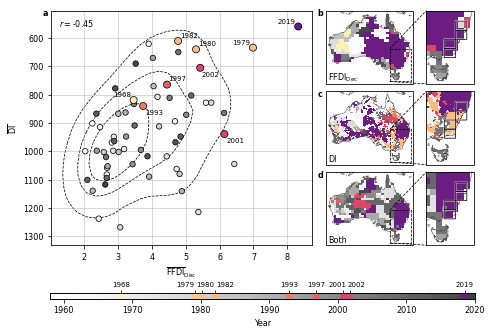

In [28]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize}

with plt.rc_context(rc_context):
    fig = plot_Fig_2(
        jra_FFDI_reg['FFDI_DEC'].compute(),
        awap_DI_reg['precip_ann'].compute(),
        jra_FFDI_jragrid['FFDI_DEC'].compute(),
        awap_DI_awapgrid['precip_ann'].compute(),
        jra_FFDI_jragrid['FFDI_DEC'].compute(),
        awap_DI_jragrid['precip_ann'].compute(),
        jra_FFDI_jragrid['FFDI_DEC'].compute(),
        awap_DI_awapgrid['precip_ann'].compute(),
        bad_years,
        custom_cmap=custom_cmap,
        figsize=(7.6,5.8))
    
fig.savefig(f'./figures/precedent.pdf', format='pdf',
        bbox_inches='tight')

## Plot Fig Supp2 for paper

In [15]:
def plot_Fig_S2(awap_precip_ann_reg, figsize=(5.9,2.0)):
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    yticks = range(400, 1700, 300)
    col = cm.get_cmap('magma')(0.3)

    ax = fig.add_subplot(111)
    ax.grid(zorder=-1, linewidth=0.5)
    ax.plot(awap_precip_ann_reg.time, awap_precip_ann_reg, 
            linestyle='-', color=col, linewidth=1)

    ax.set_ylabel(r'$\overline{\mathrm{DI}}$')
    xticks = [f'{y}-12-31' for y in range(1899, 2021,5)]
    xticklabels = [f'{y}' for y in range(1899, 2021,5)]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels, rotation=40, ha='right', rotation_mode='anchor')
    yticks = np.sort(np.concatenate(
        (ax.get_yticks(), [awap_precip_ann_reg.min().values])))
    ax.set_yticks(yticks)
    
    return fig

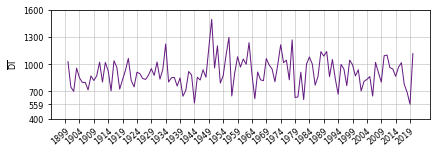

In [16]:
ax_color = 'k'
fontsize = 8
rc_context = {'axes.edgecolor':ax_color, 
              'xtick.color':ax_color, 
              'ytick.color':ax_color,
              'axes.labelcolor': ax_color,
              'text.color': ax_color,
              'font.size': fontsize}

with plt.rc_context(rc_context):
    fig = plot_Fig_S2(my.open_zarr('data/AWAP_precip-annDEC-accl_region.zarr')['precip_ann'],
                      figsize=(5.9,2.0))
    
fig.savefig(f'./figures/DI_record.pdf', format='pdf',
            bbox_inches='tight')

--------
# End notebook